<div style="border-bottom: 15px linear-gradient(to right, red, blue); margin-top: 10px; width: 100%;"></div>


<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

# TAXI DRIVER APPLICATION STATISTICS AND ANALYTICS

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

## About
Conduct data analysis to examine driver departures from the cab company to identify differences between drivers who have left and those who remain. Hypotheses should be formulated and tested, and key segments of drivers most at risk of leaving should be identified. Based on the findings, conclusions should be drawn as to which aspects of the service can be improved to make appropriate changes in the future.

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import scikit_posthocs as sp

import seaborn as sns
import plotly.express as px
import matplotlib as mplt
import matplotlib.pyplot as plt

In [2]:
sns.set(style="whitegrid")

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

## Defining Functions

In [3]:
# Info about DataFrame
def overview(df):
    print(" DATA INFO ".center(50,'-'))
    print(df.info())
    
    print(" SHAPE OF DATASET ".center(50,'-'))
    print('Rows:{}'.format(df.shape[0]))
    print('Columns:{}'.format(df.shape[1]))
    
    print(" DATA TYPES ".center(50,'-'))
    print(df.dtypes)
    
    print(" STATISTICS OF DATA ".center(50,'-'))
    print(df.describe(include="all", datetime_is_numeric=True))
    
    print(" MISSING VALUES ".center(50,'-'))
    print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))
    
    print(" DUPLICATED VALUES ".center(50,'-'))
    print(df.duplicated().sum())

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

## Uploading and Obtaining Information

In [4]:
df_taxi = pd.read_csv('data\churn.csv')
df_taxi.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Data description

- `city` - city
- `phone` - the main device used by the driver 
- `signup_date` - date of account registration (`YYYYYYYMMDD`)
- `last_trip_date` - date of the last trip (`YYYYYYMMDD`)
- `avg_dist` - average distance (in miles) per trip in the first 30 days after registration
- `avg_rating_by_driver` - average rating of trips by driver 
- `avg_rating_of_driver` - average rating of driver trips
- `surge_pct` - percentage of trips made with a multiplier > 1 (seems to be when there is heavy traffic, etc.)
- `avg_surge` - average surge multiplier for all trips for this driver
- `trips_in_first_30_days` - number of trips taken by the driver in the first 30 days after registration
- `luxury_car_user` - TRUE if the user used a premium car in the first 30 days
- `weekday_pct` - percentage of user's trips made on weekdays

In [5]:
df_taxi.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

In [6]:
# Change to date type after checking
df_taxi.last_trip_date = pd.to_datetime(df_taxi.last_trip_date)
df_taxi.signup_date = pd.to_datetime(df_taxi.signup_date)

In [7]:
overview(df=df_taxi)

------------------- DATA INFO --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       


### Note 
Many rating values are empty since it appears after a critical mass of ratings has been accumulated

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

## Hypothesis Testing and Visualization

User has left if inactive for 30 days

-  `days_since_last_trip` - Number of days elapsed since the last trip

In [8]:
# df_taxi['days_since_last_trip'] = (df_taxi.last_trip_date.max() - df_taxi.last_trip_date).dt.days
# df_taxi.days_since_last_trip

-  `churn` - drivers' churn rate

In [9]:
df_taxi['churn'] = (df_taxi.last_trip_date.max() - df_taxi.last_trip_date) \
                            .dt.days \
                            .apply(lambda x: 'churn' if x > 30 else 'not_churn')

In [10]:
df_taxi.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,not_churn
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,churn
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,churn
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,not_churn
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,churn


In [11]:
print('Number of people who left: {}'.format(df_taxi
                                                 .query('churn == "churn"')
                                                 .shape[0]))
print('Number of all people:      {}'.format(df_taxi
                                                 .shape[0]))

Number of people who left: 31196
Number of all people:      50000


### Note
Notice that a significant number of users have had no activity on the platform over the last month. Consequently, an analysis is required to identify the factors influencing driver disengagement.

In [12]:
# Count parts precents of churn rate
df_taxi.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

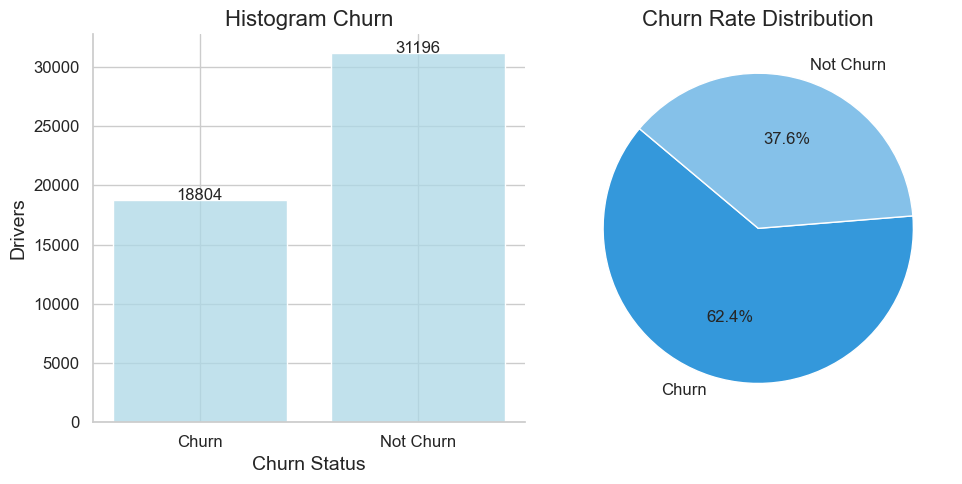

In [13]:
# Visualization of churn rate - Histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=df_taxi, 
             x='churn', 
             stat='count', 
             color='lightblue', 
             edgecolor='white', 
             shrink=0.8, 
             binwidth=1,
             ax=ax1)

ax1.set_title("Histogram Churn", fontsize=16)
ax1.set_xlabel("Churn Status", fontsize=14)
ax1.set_ylabel("Drivers", fontsize=14)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Churn', 'Not Churn'], fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2., height + 5, f"{int(height)}", ha="center", fontsize=12)

# Visualization of churn rate - Pie Chart
ax2.pie(df_taxi['churn'].value_counts(), labels=['Churn', 'Not Churn'], colors=['#3498db', '#85c1e9'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
ax2.set_title("Churn Rate Distribution", fontsize=16)

plt.tight_layout()
sns.despine(ax=ax1)
plt.show()

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

 ## Churn on Mobile Platforms

In [14]:
pd.crosstab(df_taxi.churn, df_taxi.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


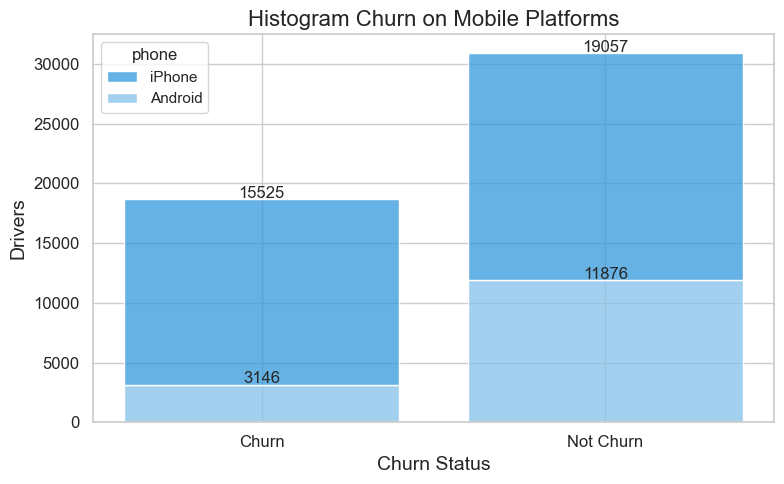

In [15]:
# Vizualization of churn rate
plt.figure(figsize=(8, 5))
fig = sns.histplot(data=df_taxi[['churn', 'phone']], 
                   x='churn', 
                   stat='count', 
                   hue=df_taxi.phone,
                   edgecolor='white', 
                   palette={'iPhone': '#3498db', 'Android': '#85c1e9'},
                   multiple='stack',
                   shrink=0.8, 
                   binwidth=1,
                   fill=True
                  )

plt.title("Histogram Churn on Mobile Platforms", fontsize=16)
plt.xlabel("Churn Status", fontsize=14)
plt.ylabel("Drivers", fontsize=14)

plt.xticks([0, 1], ['Churn', 'Not Churn'], fontsize=12)
plt.yticks(fontsize=12)

for p in fig.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., p.get_y()+height+100, f"{int(height)}", ha="center", fontsize=12)

plt.tight_layout()
plt.show()

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

## Churn by City

`churn` and `city` are categorical variables, therefore, a chi-square test (*χ2*-test) is used to determine the relationship between two categorical variables

In [16]:
tab = pd.crosstab(df_taxi.churn, df_taxi.city)
tab

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


In [17]:
stat, p, dof, expected =ss.chi2_contingency(tab)
print(stat, p, dof, expected, sep='\n')

3821.5510225559633
0.0
2
[[10315.89328  6320.3096  14559.79712]
 [ 6218.10672  3809.6904   8776.20288]]


### Note 
The results suggest that there is a statistically significant relationship between the variables in the contingent tab table because the p-value is very close to zero. This means that the null hypothesis of independence of the variables is rejected in favor of the alternative hypothesis that there is a relationship between the variables.

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

## Difference in Activity in the First 30 Days of Drivers by City

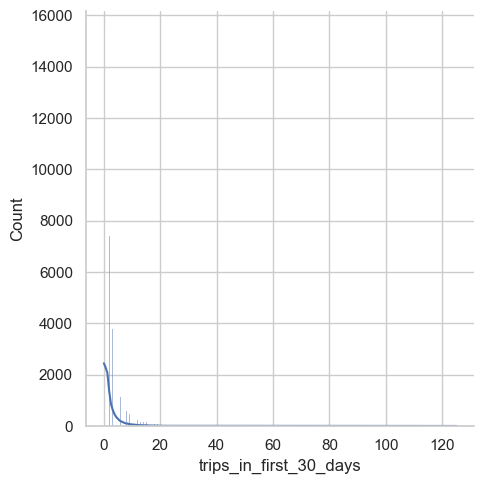

In [18]:
sns.displot(df_taxi.trips_in_first_30_days, 
            kde=True, 
           )
plt.show()

In [19]:
Astapor = df_taxi[df_taxi.city == 'Astapor'].trips_in_first_30_days
Kings = df_taxi[df_taxi.city == "King's Landing"].trips_in_first_30_days
Winterfell = df_taxi[df_taxi.city == 'Winterfell'].trips_in_first_30_days

print(ss.shapiro(Astapor.sample(1000, random_state=17)))
print(ss.shapiro(Kings.sample(1000, random_state=17)))
print(ss.shapiro(Winterfell.sample(1000, random_state=17)))

ShapiroResult(statistic=0.5414707660675049, pvalue=4.203895392974451e-45)
ShapiroResult(statistic=0.6132168769836426, pvalue=1.6829594556541053e-42)
ShapiroResult(statistic=0.545579195022583, pvalue=7.006492321624085e-45)


### Note
In this case, all three p-values are very close to zero, which means that the null hypothesis of normality of the data is rejected. Thus, we can conclude that the data on the number of trips in the first 30 days do not follow a normal distribution.

Accordingly, the Kraskell-Wallis test may be a more appropriate choice than the Shapiro-Wilk test for each group separately.

In [20]:
kruskal_results = ss.kruskal(Astapor, Kings, Winterfell)
kruskal_results

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

### Note
We can conclude that there are statistically significant differences in the number of trips in the first 30 days between the cities of Astapor, Kings, and Winterfell. The P-value is very small, indicating that the differences between the groups cannot be explained by chance and you can consider the results statistically significant.

---
A post-hoc Dunn's test adjusted for Hill's method to compare groups of data (Astapor, King's Landing, and Winterfell) on the number of trips in the first 30 days and determine between which pairs of groups there are statistically significant differences

In [21]:
sp.posthoc_dunn(df_taxi[['city', 'trips_in_first_30_days']],
                val_col='trips_in_first_30_days', 
                group_col='city', 
                p_adjust='holm'
               )

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


### Note
The p-values between groups range from very close to zero (2.448501e-49, 8.440212e-10, etc.), which means that the differences between groups are statistically significant.

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

## Difference in Activity in the First 30 Days

In [22]:
churn = df_taxi[df_taxi.churn == "churn"].trips_in_first_30_days
not_churn = df_taxi[df_taxi.churn == "not_churn"].trips_in_first_30_days

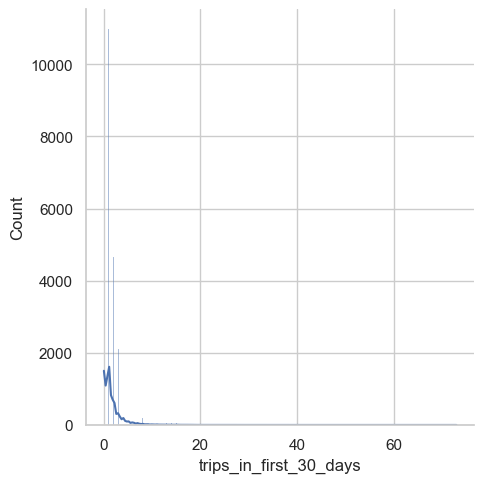

In [23]:
sns.displot(churn, kde=True)
plt.show()

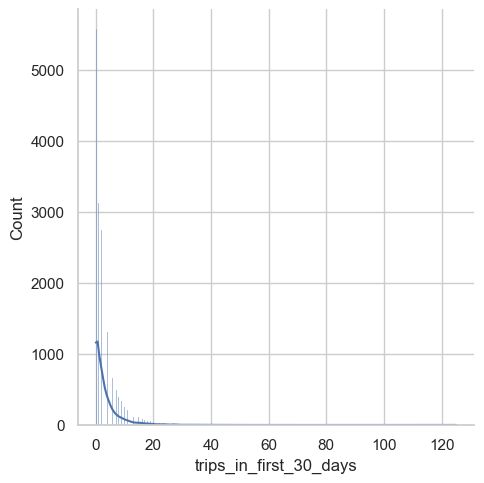

In [24]:
sns.displot(not_churn, kde=True)
plt.show()

The distributions are not normal so the Mann-Whitney U-test is used

In [25]:
ss.mannwhitneyu(churn, not_churn)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

### Note
A P-value close to zero indicates that the null hypothesis of equality of distributions between your two groups is rejected. Thus, the results indicate that there are statistically significant differences

<Axes: xlabel='churn', ylabel='trips_in_first_30_days'>

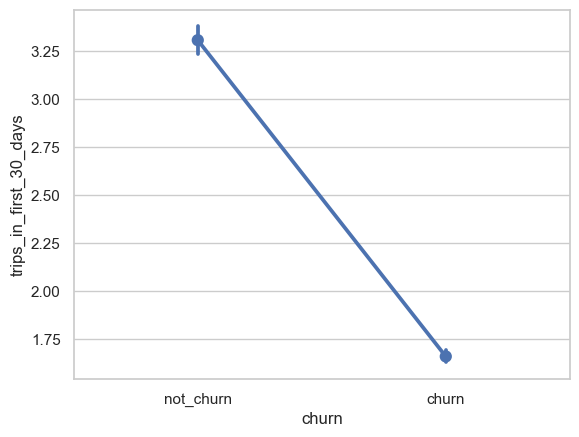

In [26]:
sns.pointplot(data=df_taxi, x='churn', y='trips_in_first_30_days')

<div style="border-bottom: 15px solid lightblue; border-radius: 10px; width: 100%;"></div>

### Conclusion
This finding may make practical sense when analyzing user behavior and the reasons why they may have left. Perhaps activity in the first 30 days plays a role in user retention, and differences in activity between cities may have influenced users' decision to stay or leave.